# Проект "Анализ оттока клиентов банка 'Метанпром'

###### Цель:
Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка «Метанпром».

###### Материалы: 

Презентация: https://disk.yandex.ru/i/SjfDNrOLJ7kH2A

Дашборд: https://public.tableau.com/app/profile/veronika.kabantseva/viz/Metanprombank_16871685278320/Dashboard1

## Загрузка данных

In [1]:
!pip install phik

In [2]:
# импорт необходимых библиотек

import pandas as pd
import datetime as dt
import seaborn as sns
import math as mth
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
import warnings
from plotly import graph_objects as go
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

import phik
from phik import report
from phik.report import plot_correlation_matrix

In [3]:
#полный вид строк и столбцов
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50
#формат вывода данных в ячейках
#pd.options.display.float_format ='{:,.1f}'.format

In [4]:
bank_df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv') #загрузка файла

## Предобработка данных

### Общая информация о датафрейме

In [5]:
#функция с основной информацией о датафрейме
def basic_information(df):
    print('Общая информация о датафрейме:')
    print(df.info())
    print('********************************')
    print('Первые 5 строк датафрейма:')
    print(df.head())
    print('********************************')
    print('Количество пропусков в датафрейме:')
    print(df.isna().sum())
    print('********************************')
    print('Количество дубликатов в датафрейме:')
    print(df.duplicated().sum())

In [6]:
basic_information(bank_df)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None
********************************
Первые 5 строк датафрейма:
   USERID  score       city gender   age  equity     balance  products  \
0  183012  850.0    Рыбинск      Ж  25.0  

В датафрейме 10000 записей, пропуски присутствуют в столбцах с данными о возрасте ('age') и c остатком на счете ('balance'), дальше следует проверить, есть ли взаимосвязь пропусков с другими значениями в таблице.  Полные дубликаты не обнаружены, стоит проверить наличие задвоенных значений, например, 'userid'.

Перед анализом приведем названия столбцов к нижнему регистру

In [7]:
bank_df.columns = bank_df.columns.str.lower()

### Обработка пропусков

Проанализируем пропуски для определения, можно ли их корректно заполнить или удалить без потери информативности. 

In [8]:
nan_age = bank_df['age'].isna().sum() *100 / bank_df['age'].count()
nan_age

0.2606777621816723

Строки с пропусками в столбце 'age' составляют менее 0,3% от общего количества строк. Было принято решение удалить такие строки, т.к. они не повлияют на результаты анализа.

In [9]:
bank_df = bank_df.dropna(subset = ['age'], axis = 0)

In [10]:
nan_balance = bank_df.loc[bank_df.isnull().any(axis = 1)]
nan_balance

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876.0,Ростов,М,38.0,0,NaN,1,0,0,171763.69,0
9984,125941,729.0,Ярославль,Ж,42.0,0,NaN,1,1,1,687538.70,0
9993,219924,884.0,Рыбинск,Ж,36.0,0,NaN,1,1,1,169844.88,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0


Отсутствие значений баланса в датафрейме значительное. Посмотрим пропущенные значения в зависимости от города, количества продуктов, наличия кредитной карты, оценки собственности и является ли клиент действующим на текущий момент. 

In [11]:
for column in ['city', 'products', 'credit_card', 'equity', 'last_activity', 'churn']:
    print(column)
    print(round(nan_balance[column].value_counts(normalize=True),3))
    print() 

city
Ярославль    0.640
Рыбинск      0.257
Ростов       0.103
Name: city, dtype: float64

products
1    0.849
2    0.138
3    0.013
0    0.000
Name: products, dtype: float64

credit_card
1    0.815
0    0.185
Name: credit_card, dtype: float64

equity
0    0.95
1    0.05
3    0.00
Name: equity, dtype: float64

last_activity
1    0.549
0    0.451
Name: last_activity, dtype: float64

churn
0    0.994
1    0.006
Name: churn, dtype: float64



На основе информации полученной выше, больше всего пропусков у клиентов из Ярославля (ошибка системы?). Также значение баланса отсутствует у оставшихся клиентов с 1 продуктом - кредитной картой (81%). 

Таким образом, логично заполнить пропуски в данном столбце не представляется возможным. Удаление приведет к большой потере данных, а замена может исказить дальнейшие результаты.

Изменим тип данных в столбцах 'age', 'score' на целочисленный.

In [12]:
bank_df['age'] = bank_df['age'].astype('int')
bank_df['score'] = bank_df['score'].astype('int')

### Обработка дубликатов

Так как полные дубликаты не обнаружены, выполним проверку на неявные дубликаты, которые могут появиться в случаях, когда данные собирались из разных источников или в системе были какие-то сбои при логировании.

In [13]:
duplicaterows = bank_df[bank_df.duplicated(['userid'])]
duplicaterows['userid'].count()

50

Обнаружено 50 дубликата 'userid'. Посмотрим, точно ли они являются дубликатами.

In [14]:
bank_df[bank_df["userid"].isin(bank_df["userid"][bank_df["userid"].duplicated()])].sort_values("userid")

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1
5896,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0
1411,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1
8638,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1


В данных строках повторяется только 'userid', в остальных столбцах значения разные, поэтому удалять их из датафрейма не стоит. Возможно в разных городах по-разному идет присвоение идентификационного номера (нет общей базы), поэтому и получилось задвоение 'userid'.

### Обработка аномалий

Проверим столбцы с числовыми значениями на предмет аномалий.

In [15]:
bank_df[['score','age','equity', 'balance', 'products', 'est_salary']].describe()

,score,age,equity,balance,products,est_salary
count,9974.000000,9974.000000,9974.000000,7.695000e+03,9974.000000,9.974000e+03
mean,848.682575,42.734409,2.630840,8.272456e+05,1.871466,1.477868e+05
std,65.399720,12.179971,1.979965,1.980327e+06,0.792729,1.392855e+05
min,642.000000,18.000000,0.000000,0.000000e+00,0.000000,2.546300e+03
25%,802.000000,33.000000,0.000000,2.956987e+05,1.000000,7.525166e+04
50%,853.000000,40.000000,3.000000,5.242953e+05,2.000000,1.196268e+05
75%,900.000000,51.000000,4.000000,9.800512e+05,2.000000,1.744998e+05
max,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.395064e+06


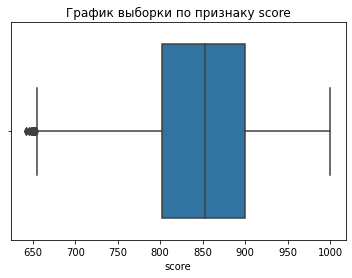

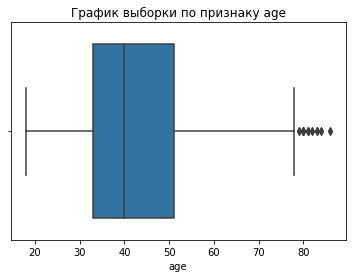

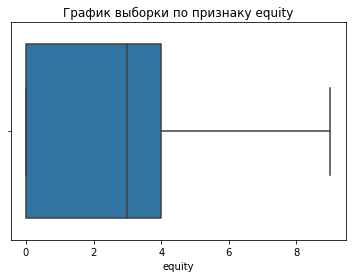

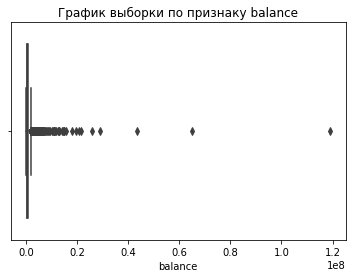

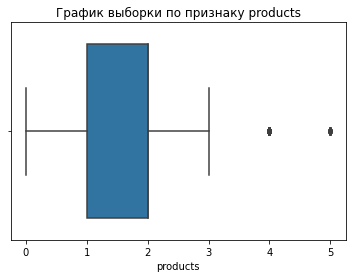

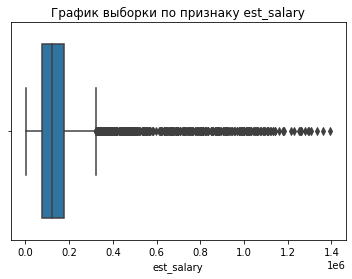

In [16]:
for column in ['score','age', 'equity', 'balance', 'products', 'est_salary']:
    fig,ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=bank_df, x=column, dodge=True)
    plt.title(f'График выборки по признаку {column}', fontsize = 12)
    plt.show()

На графиках выборки видны большие хвосты в значениях баланса и заработной платы. Однако такое распределение зарплаты соответствует экономической ситуации и данные значения не являются выбросами.

###### Вывод:
Была выполнена предобработка данных, а именно: 
 * Названия столбцов приведены к нижнему регистру;
 * Исследована природа пропусков. Принято решение удалить строки с пропусками в столбце 'age' и смириться с пропусками в столбце 'balance';
 * Изменены типы данных в столбцах 'age' и 'score' на целочисленный;
 * Обнаружены задвоения 'userid', однако остальные значения различаются. Принято решение ничего не делать с такими строками;
 * Построены графики выборки по численным характеристикам. Отфильтрованы аномальные значения в столбцах 'balance' и 'est_salary'.


## Исследовательский анализ данных

### Распределение клиентов банка по разным признакам

Для начала посмотрим общий портрет клиентов банка.

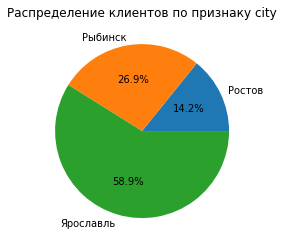

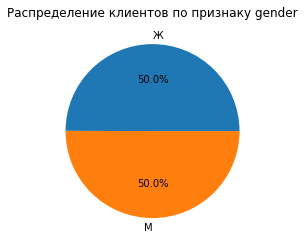

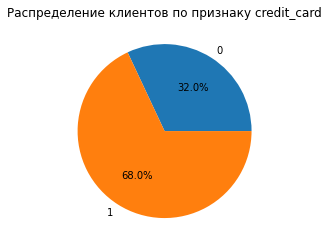

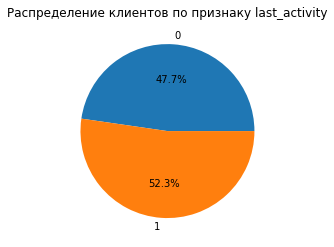

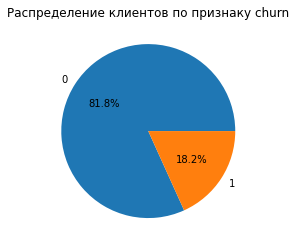

In [19]:
#дискретные значения
colors = sns.color_palette('tab10')
for column in ['city', 'gender', 'credit_card', 'last_activity', 'churn']:
    group = bank_df.pivot_table(index = column, values = 'userid', aggfunc = 'count')
    plt.pie(group['userid'], labels=group.index, colors = colors, autopct='%.1f%%')
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

Большинство клиентов из Ярославля, что логично - это самый крупный город из предложенных. Соотношение мужчин и женщин - 50/50. Кредитную карту имеют 68% клиентов. Большинство клиентов (50%) имеют 2 продукта от банка. 48% процентов клиентов давно не пользовалось услугами банка. Количество ушедших клиентов составляет 18%, это достаточно значимая цифра.

Рассмотрим распределение клиентов в зависимости от баллов собственности и количества продуктов.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


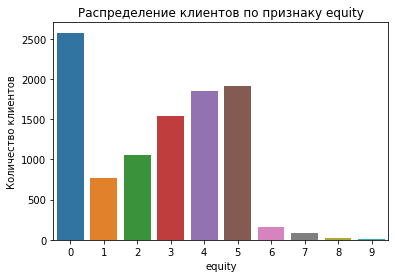

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


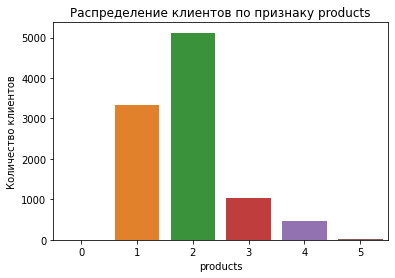

In [20]:
for column in ['equity', 'products']:
    sns.countplot(bank_df[column])
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.ylabel('Количество клиентов')
    plt.show()

Клиентами банка в основном являются люди, пользующиеся 1-2 продуктами банка, неимеющие баллов или имеющие 4-5 баллов собственности.

Рассмотрим распределение клиентов банка по возрасту, балансу на счете и заработной плате.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


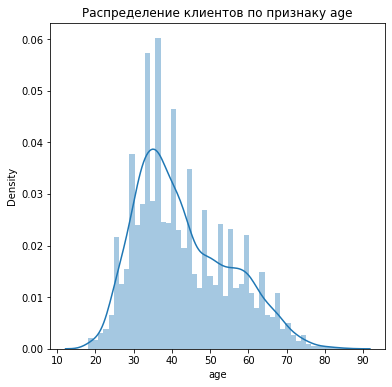

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


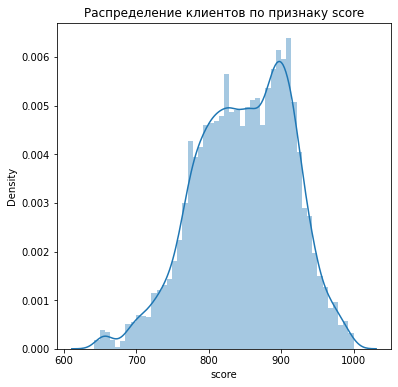

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


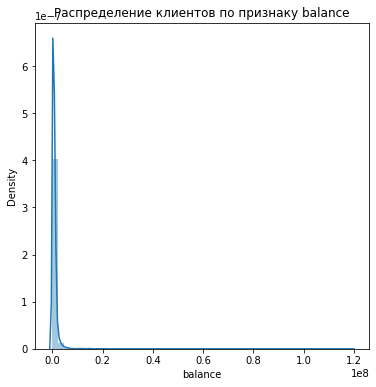

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


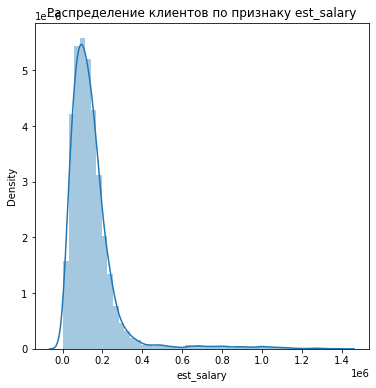

In [21]:
for column in ['age', 'score', 'balance', 'est_salary']:
    fig,ax = plt.subplots(figsize=(6, 6))
    sns.distplot(bank_df[column], hist=True,  bins=50) 
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()

Превалирующее число клиентов банка в возрасте от 25 до 45 лет, с рейтингом 750-950, имеющие от 100 тыс до 1,5 млн.руб. на балансе и с заработной платой 100 тыс. до 400 тыс.

### Распределение клиентов банка по разным признакам в зависимости от статуса

           Остались  Ушли  Процент_оттока
city                                     
Ростов         1151   265       18.714689
Рыбинск        2246   437       16.287738
Ярославль      4758  1117       19.012766


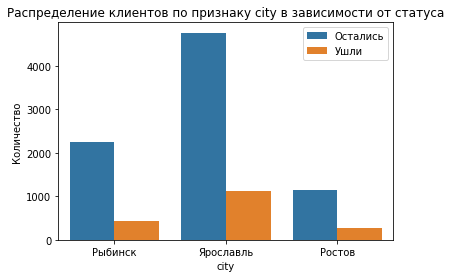

        Остались  Ушли  Процент_оттока
gender                                
Ж           4347   636       12.763396
М           3808  1183       23.702665


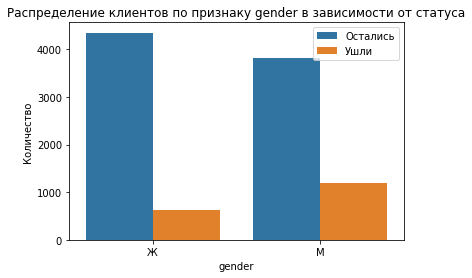

             Остались  Ушли  Процент_оттока
credit_card                                
0                2374   816       25.579937
1                5781  1003       14.784788


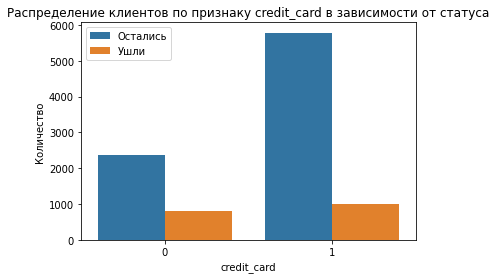

               Остались  Ушли  Процент_оттока
last_activity                                
0                  4217   542       11.388947
1                  3938  1277       24.487057


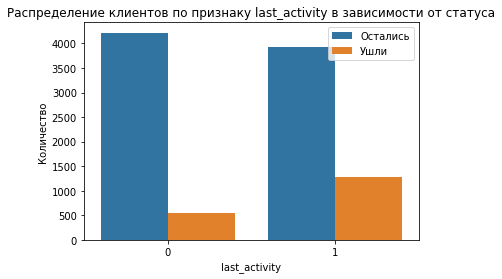

        Остались  Ушли  Процент_оттока
equity                                
0           2486    90        3.493789
1            680    93       12.031048
2            885   166       15.794481
3           1219   322       20.895522
4           1383   464       25.121819
5           1339   576       30.078329
6            103    58       36.024845
7             43    37       46.250000
8             11     6       35.294118
9              6     7       53.846154


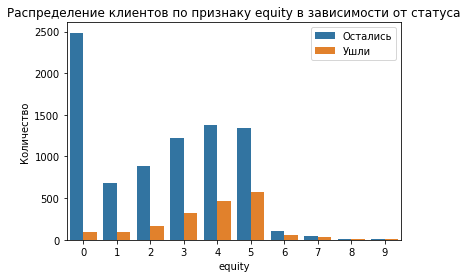

          Остались   Ушли  Процент_оттока
products                                 
0              NaN    1.0             NaN
1           3088.0  235.0        7.071923
2           4141.0  978.0       19.105294
3            741.0  297.0       28.612717
4            174.0  300.0       63.291139
5             11.0    8.0       42.105263


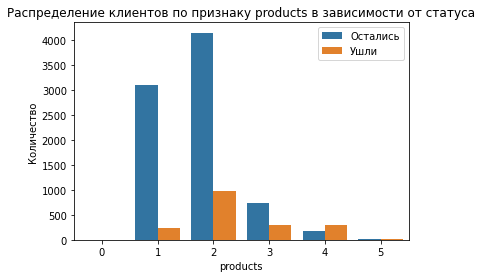

In [22]:
for column in ['city','gender', 'credit_card', 'last_activity', 'equity', 'products']:
    group = bank_df.pivot_table(index = column, columns = 'churn', values = 'userid', aggfunc = 'count')
    group.columns = ['Остались', 'Ушли']
    group['Процент_оттока'] = group['Ушли'] *100 / (group['Ушли']+group['Остались'])
    print(group)
    ax = sns.countplot(data=bank_df, x=column, hue='churn');
    plt.title(f'Распределение клиентов по признаку {column} в зависимости от статуса')
    plt.legend(['Остались', 'Ушли'])
    plt.ylabel('Количество')
    plt.show()

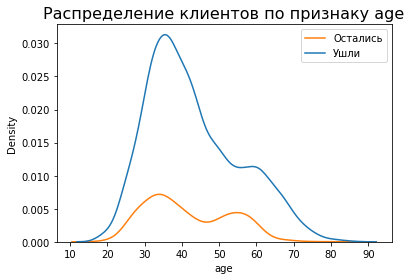

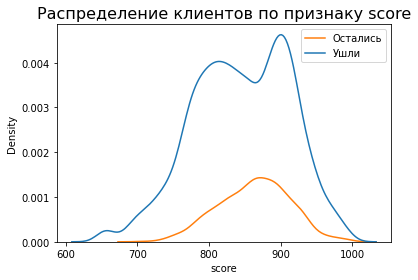

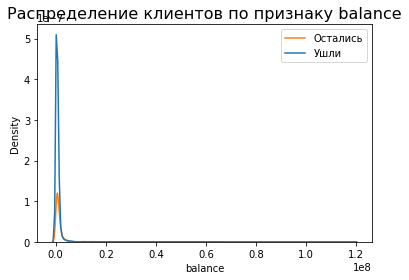

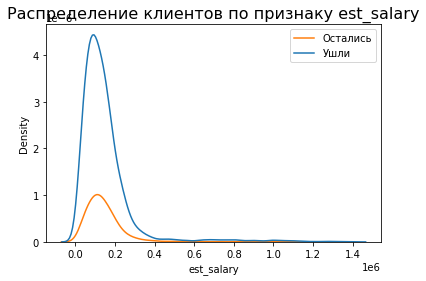

In [23]:
for column in ['age', 'score',  'balance', 'est_salary']:
    sns.kdeplot(data=bank_df, x=column, hue='churn');
    plt.title(f'Распределение клиентов по признаку {column}', fontsize = 16, color = 'black')
    plt.legend(['Остались', 'Ушли'])
    plt.show()

###### Вывод: 
Самый большой отток в Ярославле и Рыбинске (~19%). Мужчины более склонны к уходу, чем женщины(23,7% против 12,8%). Гораздо чаще уходят клиенты, не имеющие кредитной карты в банке. Также в два раза выше процент оттока у активных клиентов. Если рассматривать  количество баллов собственности – чем больше баллов,  тем выше процент оттока. Самый высокий процент оттока(63%) у клиентов с 4 продуктами от банка.

Построим график плотности вероятностей, чтобы увидеть значения признаков при которых клиенты уходят чаще.

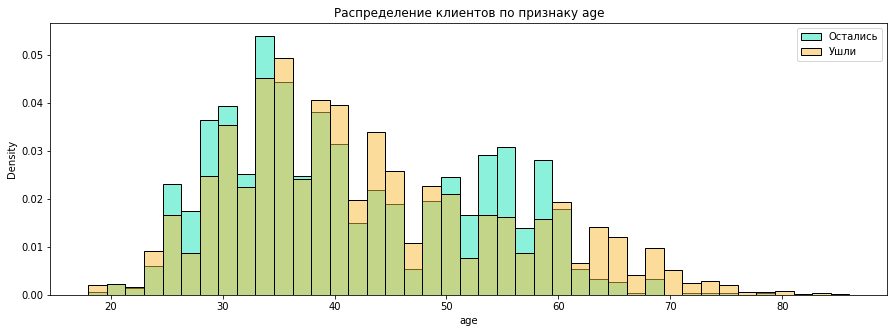

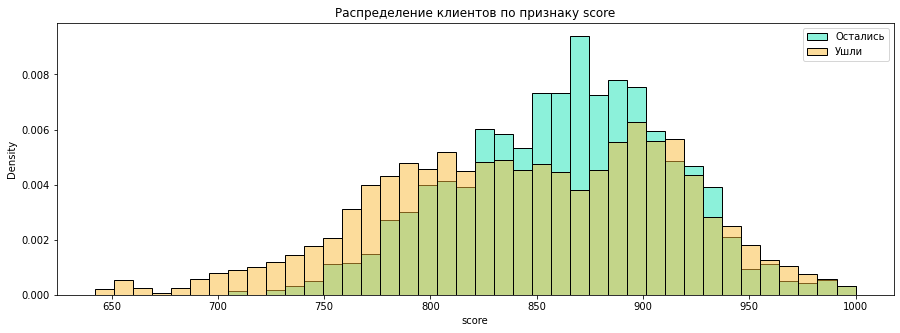

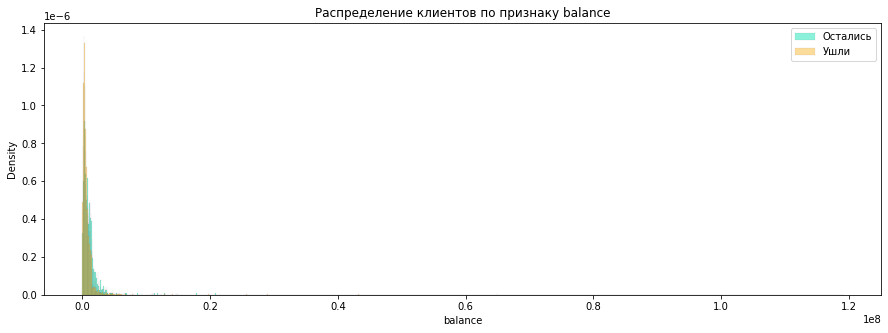

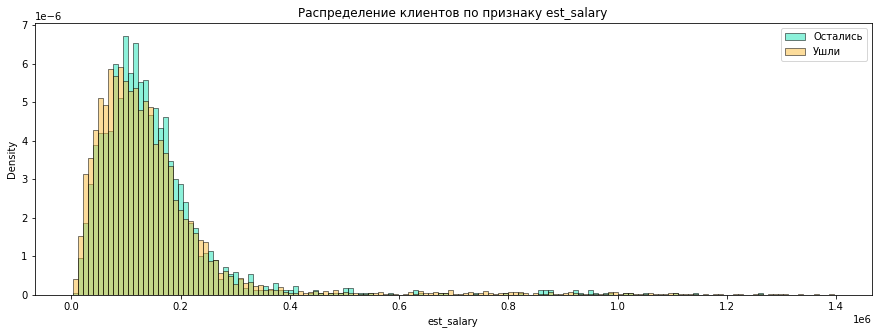

In [24]:
for column in ['age', 'score', 'balance', 'est_salary']:
    plt.figure(figsize=(15, 5))
    sns.histplot(data = bank_df, hue = 'churn', x = column, stat = 'density', common_norm = False, palette = 'turbo_r')
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.legend(['Остались', 'Ушли'])
    plt.show()

Наиболее склонны к оттоку клиенты в возрасте 35-50 лет и старше 60 лет. Наиболее часто уходят клиенты с назким кредитным скорингом - менее 800.

### Построение матрицы корреляции

Построим матрицу корреляции Phik, чтобы определить, коррелируют ли какие-либо признаки между собой.

In [25]:
for_matrix = bank_df.drop(['userid'], axis=1)

In [26]:
interval_cols=for_matrix[['balance','est_salary','age','score']]

In [27]:
phik_overview = for_matrix.phik_matrix(interval_cols=interval_cols)
phik_overview

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
score,1.000000,0.090925,0.070446,0.036178,0.527334,0.170887,0.307399,0.208318,0.053418,0.395214,0.228080
city,0.090925,1.000000,0.011924,0.093705,0.062559,0.039931,0.223196,0.074660,0.030399,0.170948,0.016431
gender,0.070446,0.011924,1.000000,0.286026,0.063699,0.045434,0.122023,0.195831,0.012733,0.144090,0.219731
age,0.036178,0.093705,0.286026,1.000000,0.043708,0.024989,0.133418,0.157196,0.089172,0.358167,0.182538
equity,0.527334,0.062559,0.063699,0.043708,1.000000,0.000000,0.441413,0.221467,0.051218,0.285543,0.352103
balance,0.170887,0.039931,0.045434,0.024989,0.000000,1.000000,0.000000,0.000000,0.000000,0.374366,0.024672
products,0.307399,0.223196,0.122023,0.133418,0.441413,0.000000,1.000000,0.459117,0.191921,0.157477,0.440923
credit_card,0.208318,0.074660,0.195831,0.157196,0.221467,0.000000,0.459117,1.000000,0.049306,0.038496,0.202374
last_activity,0.053418,0.030399,0.012733,0.089172,0.051218,0.000000,0.191921,0.049306,1.000000,0.044890,0.262164
est_salary,0.395214,0.170948,0.144090,0.358167,0.285543,0.374366,0.157477,0.038496,0.044890,1.000000,0.048803


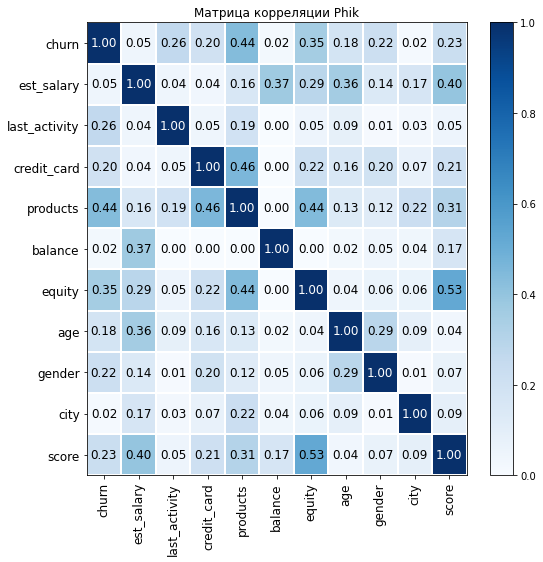

In [28]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.2,
                        figsize=(8,8))
plt.tight_layout()
plt.title('Матрица корреляции Phik')
plt.show()

По матрице корреляции видно, что большой зависимости между признаками нет. Существует небольшая зависимость между количеством продуктов банка и вероятностью ухода (53%)

## Сегментация клиентов банка

По результатам проведенного анализа были выделены следующие 3 сегмента клиентов банка:
 * Мужчины, пользующиеся двумя и более продуктами банка, но не имеющие кредитную карту;
 * Клиенты из Ярославля и Ростова, которые являются активными пользователями с 2-4 баллами собственности;
 * Клиенты, имеющие зарплату более 100 тыс.рублей, более 500 тыс. на счете и не имеющие кредитную карту.

Количество клиентов в сегменте: 1079
Показатель оттока в сегменте: 41.24


Text(0, 0.5, 'Количество')

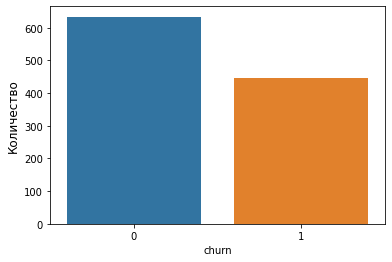

In [29]:
seg1 = bank_df.query('gender == "М" & products >= 2 & credit_card == 0')
ottok = round((seg1.query('churn == 1').count() *100 / seg1.count()), 2)
print('Количество клиентов в сегменте:', len(seg1))
print('Показатель оттока в сегменте:', ottok['churn'])
ax = sns.countplot(data=seg1, x = 'churn')
ax.set_ylabel('Количество', fontsize = 12, color='black')

Количество клиентов в сегменте: 1567
Показатель оттока в сегменте: 31.72


Text(0, 0.5, 'Количество')

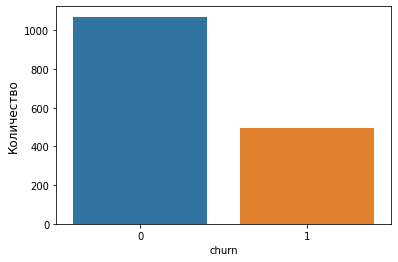

In [30]:
seg2 = bank_df.query('city != "Рыбинск" & 2<=equity<=4 & last_activity == 1')
ottok = round((seg2.query('churn == 1').count() *100 / seg2.count()), 2)
print('Количество клиентов в сегменте:', len(seg2))
print('Показатель оттока в сегменте:', ottok['churn'])
ax = sns.countplot(data=seg2, x = 'churn')
ax.set_ylabel('Количество', fontsize = 12, color='black')

Количество клиентов в сегменте: 1103
Показатель оттока в сегменте: 43.7


Text(0, 0.5, 'Количество')

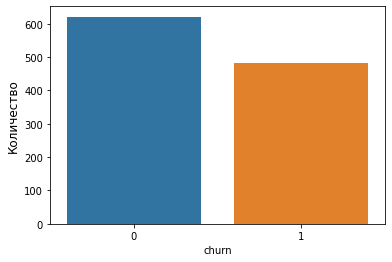

In [31]:
seg3 = bank_df.query('balance > 500000 & credit_card == 0 & est_salary > 100000')
ottok = round((seg3.query('churn == 1').count() *100 / seg3.count()), 2)
print('Количество клиентов в сегменте:', len(seg3))
print('Показатель оттока в сегменте:', ottok['churn'])
ax = sns.countplot(data=seg3, x = 'churn')
ax.set_ylabel('Количество', fontsize = 12, color='black')

Вывод: По итогам анализа сегментов получилось, что самый высокий показатель оттока - 44% у хорошо обеспеченных клиентов, имеющих зарплату более 100 тыс.рублей, более 500 тыс. на счете и не имеющие кредитную карту. На втором месте клиенты - мужчины, пользующиеся двумя и более продуктами банка, но не имеющие кредитную карту, отток в этом сегменте составляет 41%. Замыкают тройку клиенты из Ярославля и Ростова, которые являются активными пользователями с 2-4 баллами собственности, у них отток 32%.

## Проверка статистических гипотез

Для проверки гипотез будем применять t-тест, так как наиболее частые случаи применения t-критерия связаны как раз с проверкой равенства средних значений в двух выборках.

Значение alpha приму за 0.05 чтобы получить результат с 95-процентным уровнем достоверности.

### Проверка 1 гипотезы

Для начала сформулируем нулевую и альтернативные гипотезы:

H_0: Различий дохода между теми клиентами, которые ушли и теми, которые остались, нет.

H_a: Различия дохода между теми клиентами, которые ушли и теми, которые остались, есть.

In [32]:
client_churn = bank_df.query('churn == 1')['est_salary']
client_stayed = bank_df.query('churn == 0')['est_salary']
print('Количество ушедших клиентов:',len(client_churn))
print('Количество оставшихся клиентов:',len(client_stayed))

Количество ушедших клиентов: 1819
Количество оставшихся клиентов: 8155


In [33]:
alpha = .05

results = st.ttest_ind(client_churn, client_stayed)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8647861589211189
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получилось, значит, статистически значимых различий дохода между теми клиентами, которые ушли и теми, которые остались нет.

### Проверка 2 гипотезы

Для начала сформулируем нулевую и альтернативные гипотезы:

H_0: Различий в количестве продуктов банка между теми клиентами, которые ушли и теми, которые остались, нет.

H_a: Различия в количестве продуктов банка между теми клиентами, которые ушли и теми, которые остались, есть.

In [34]:
prod_churn = bank_df.query('churn == 1')['products']
prod_stayed = bank_df.query('churn == 0')['products']

In [35]:
alpha = .05

results = st.ttest_ind(prod_churn, prod_stayed)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.0765646697701624e-207
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, значит, статистически значимые различия в количестве продуктов банка между теми клиентами, которые ушли и теми, которые остались, есть.

## Вывод

В ходе проекты были проанализированы клиенты регионального банка "Метанпром". 

 Клиентами являются мужчины и женщины примерно в равном соотношении, с возрастом от 18 до 92 лет. Большинство клиентов из Ярославля(58,7%), далее идет Рыбинск(27%) и наименьшее количество в Ростове(14,3%). Кредитную карту имеют 68% клиентов. Большинство клиентов (50%) имеют 2 продукта от банка. 48% процентов клиентов давно не пользовалось услугами банка. Примерно половина клиентов пользуются только двумя продуктами банка. Большее числа клиентов банка имеют выскоий уровень кредитного скоринга. Платежеспособность клиентов тоже не смущает - у большинства высокий уровнь заработной платы и достаточное количество денег на балансе. 
 
 При анализе оттока клиентов выяснилось следующее - самый большой отток в Ярославле и Рыбинске (18%). Мужчины более склонны к уходу, чем женщины(23,5% против 12,7%). Гораздо чаще уходят клиенты, не имеющие кредитной карты в банке. Также в два раза выше процент оттока у активных клиентов. Если рассматривать количество баллов собственности – чем больше баллов, тем выше процент оттока. Самый высокий процент оттока(63%) у клиентов с 4 продуктами от банка.
 
 Было выделено 3 группы клиентов с высоким уровнем оттока: 
  * Мужчины, пользующиеся двумя и более продуктами банка, но не имеющие кредитную карту - 41,2% оттока;
  * Клиенты из Ярославля и Ростова, которые являются активными пользователями с 2-4 баллами собственности - 31,7% оттока;
  * Клиенты, имеющие зарплату более 100 тыс.рублей, более 500 тыс. на счете и не имеющие кредитную карту - 43,7% оттока.
 
Были проверены две статистические гипотезы методом t-критерия Стьюдента. Первую нулевую гипотезу отвергнуть не получилось, значит, статистически значимых различий дохода между теми клиентами, которые ушли и теми, которые остались нет. Вторая нулевая гипотеза была отвергнута - статистически значимые различия в количестве продуктов банка между теми клиентами, которые ушли и теми, которые остались, есть.


###### Рекомендации:
 * Предусмотреть программы лояльности для лиц мужского пола. Например, кэшбек при посещении барбершопов.
 * Предусмотреть премиальное обслуживание для клиентов с большим количеством баллов собственности, балансе на счете и высокой зарплатой.
 * Предлагать более выгодные условия по кредитной карте.
 * Привлекать людей льготными условиями кредитования